In [1]:
import numpy as np
import scipy.stats as st
from statsmodels.tsa.stattools import acovf
import glob
import matplotlib.pyplot as pl
import warnings
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
warnings.simplefilter('ignore')

In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [3]:
models = [
'ACCESS-CM2',    'CAMS-CSM1-0','CESM2-WACCM-FV2','E3SM-1-1-ECA','GISS-E2-1-G-CC', 'INM-CM4-8',    'MPI-ESM1-2-LR','NorESM2-MM',
'ACCESS-ESM1-5', 'CanESM5',    'CNRM-CM6-1',     'FGOALS-f3-L', 'GISS-E2-1-H',    'INM-CM5-0',    'MRI-ESM2-0',   'SAM0-UNICON',
'AWI-CM-1-1-MR', 'CAS-ESM2-0', 'CNRM-CM6-1-HR',  'FGOALS-g3',   'GISS-E2-2-G',    'IPSL-CM6A-LR', 'NESM3',        'UKESM1-0-LL',
'AWI-ESM-1-1-LR','CESM2',      'CNRM-ESM2-1',    'GFDL-CM4',    'HadGEM3-GC31-LL','MIROC6',       'NorCPM1',
'BCC-CSM2-MR',   'CESM2-FV2',  'E3SM-1-0',       'GFDL-ESM4',   'HadGEM3-GC31-MM','MIROC-ES2L',   'NorESM1-F',
'BCC-ESM1',      'CESM2-WACCM','E3SM-1-1',       'GISS-E2-1-G', 'IITM-ESM',       'MPI-ESM1-2-HR','NorESM2-LM',
]

models = [
'ACCESS-CM2',     'CanESM5-CanOE',   'CNRM-CM6-1',    'EC-Earth3-LR',     'GISS-E2-1-G',     'INM-CM5-0',       'NESM3',
'ACCESS-ESM1-5',  'CAS-ESM2-0',      'CNRM-CM6-1-HR', 'EC-Earth3-Veg',    'GISS-E2-1-G-CC',  'IPSL-CM6A-LR',    'NorCPM1',
'AWI-CM-1-1-MR',  'CESM2',           'CNRM-ESM2-1',   'EC-Earth3-Veg-LR', 'GISS-E2-1-H',     'MIROC6',          'NorESM1-F',
'AWI-ESM-1-1-LR', 'CESM2-FV2',                        'FGOALS-f3-L',      'GISS-E2-2-G',     'MIROC-ES2L',      'NorESM2-LM',
'BCC-CSM2-MR',    'CESM2-WACCM',     'E3SM-1-0',      'FGOALS-g3',        'HadGEM3-GC31-LL', 'MPI-ESM-1-2-HAM', 'NorESM2-MM',
'BCC-ESM1',       'CESM2-WACCM-FV2', 'E3SM-1-1',      'FIO-ESM-2-0',      'HadGEM3-GC31-MM', 'MPI-ESM1-2-HR',   'SAM0-UNICON',
'CAMS-CSM1-0',    'CIESM',           'E3SM-1-1-ECA',  'GFDL-CM4',         'IITM-ESM',        'MPI-ESM1-2-LR',   'TaiESM1',
'CanESM5',        'CMCC-CM2-SR5',    'EC-Earth3',     'GFDL-ESM4',        'INM-CM4-8',       'MRI-ESM2-0',      'UKESM1-0-LL'
]

In [4]:
piControl = {}
accepted_models = []
nyears = {}

# Models only provided r1 in any seriousness. GISS and CanESM have a couple of variants, we'll stick to r1 for consistency.
# All of this data has been pre-processed into annual mean text files. It's way too big to put on GitHub.
for model in models:
    piControl[model] = {}
    dirpiC  = glob.glob('../data_input/cmip6/%s/piControl/r1i*/' % model)
    if model=='CanESM5' or model=='GISS-E2-1-G':
        dirpiC  = [x for x in dirpiC if 'r1i1p1f1' in x]
    # experiment missing? skip model
    if len(dirpiC)==0:
        continue
    dirpiC  = dirpiC[0]
    piControl[model]['tas']  = np.loadtxt(dirpiC + 'tas.txt')
    nyears[model]  = len(piControl[model]['tas'])
    slope, intercept, _, _, _ = st.linregress(np.arange(nyears[model]), piControl[model]['tas'])
    piControl[model]['tas_driftcorrected'] = piControl[model]['tas'] - intercept - np.arange(nyears[model]) * slope
    # if we get this far, things have worked out well
    accepted_models.append(model)

In [5]:
len(accepted_models)
#nyears

49

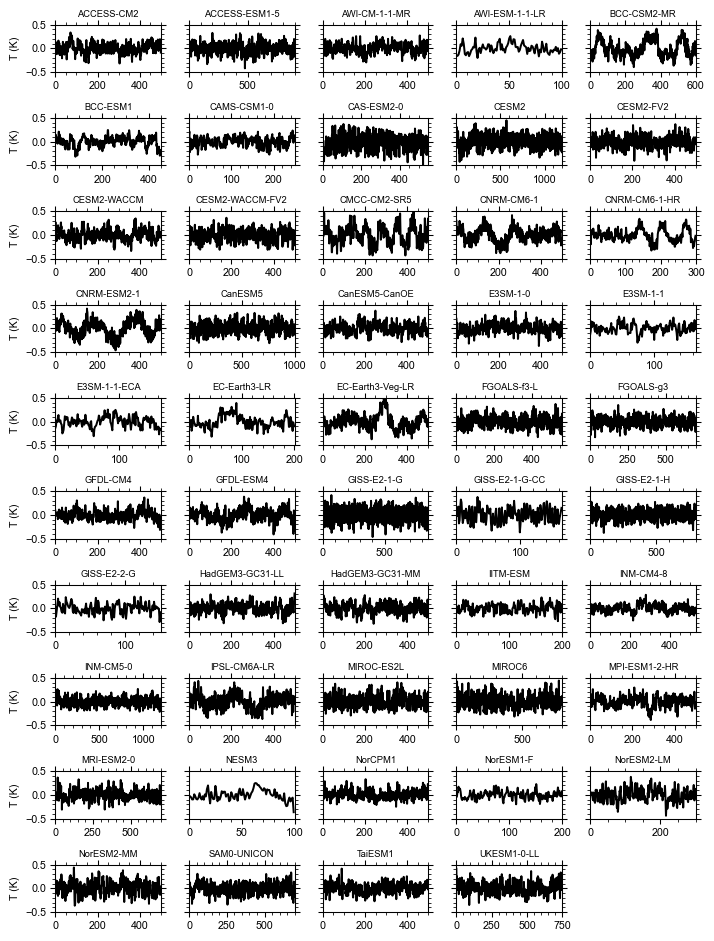

In [6]:
fig, ax = pl.subplots(10,5, figsize = (19/2.54,25/2.54))
for i, model in enumerate(sorted(accepted_models)):
    ax[i//5,i%5].plot(piControl[model]['tas_driftcorrected'], color='k')
    ax[i//5,i%5].set_title(model, fontsize=7)
    #ax[i//5,i%5].xaxis.set_label_coords(0.5, -0.12)
    #ax[i//5,i%5].set_ylabel('T (K)')
    #ax[i//5,i%5].yaxis.set_label_coords(-0.035, 0.9)
    ax[i//5,i%5].set_xlim(0,nyears[model])#(0,nyears[model])
    ax[i//5,i%5].set_ylim(-0.5,0.5)#(0,np.max(np.concatenate((tg[model],T[model])))))
    if i%5!=0:
        ax[i//5,i%5].set_yticklabels([])
ax[0,0].set_ylabel('T (K)')
ax[1,0].set_ylabel('T (K)')
ax[2,0].set_ylabel('T (K)')
ax[3,0].set_ylabel('T (K)')
ax[4,0].set_ylabel('T (K)')
ax[5,0].set_ylabel('T (K)')
ax[6,0].set_ylabel('T (K)')
ax[7,0].set_ylabel('T (K)')
ax[8,0].set_ylabel('T (K)')
ax[9,0].set_ylabel('T (K)')
#ax[8,0].set_xlabel('year')
#ax[8,1].set_xlabel('year')
#ax[8,2].set_xlabel('year')
#ax[8,3].set_xlabel('year')
#ax[7,4].set_xlabel('year')
ax[9,4].axis('off')
fig.tight_layout();
pl.savefig('../figures/figureS5.png', dpi=300)
pl.savefig('../figures/figureS5.pdf')

(0.0, 270.0)

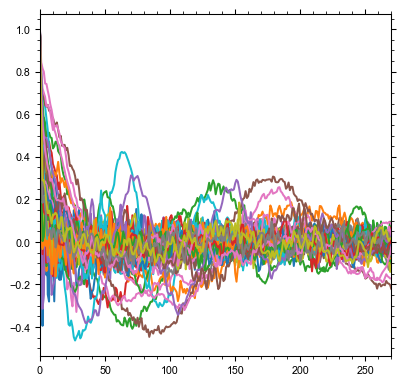

In [7]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

fig, ax = pl.subplots()
for i, model in enumerate(accepted_models):
    y = autocorr(piControl[model]['tas_driftcorrected'])
    ax.plot(y / float(y.max()))
ax.set_xlim(0,270)

In [8]:
for i, model in enumerate(accepted_models):
    print(model, np.std(piControl[model]['tas_driftcorrected']))

ACCESS-CM2 0.10385132493862548
CanESM5-CanOE 0.10798545469792807
CNRM-CM6-1 0.13644837825306644
EC-Earth3-LR 0.1234391846390136
GISS-E2-1-G 0.14520416436816566
INM-CM5-0 0.07814776628250848
NESM3 0.10878596612275282
ACCESS-ESM1-5 0.1085352124843173
CAS-ESM2-0 0.16468015493327942
CNRM-CM6-1-HR 0.13045760197778505
GISS-E2-1-G-CC 0.15225523369028074
IPSL-CM6A-LR 0.14699993026195915
NorCPM1 0.09095313758085666
AWI-CM-1-1-MR 0.10419872230192914
CESM2 0.12246176266069016
CNRM-ESM2-1 0.16053193152949297
EC-Earth3-Veg-LR 0.15990323841379228
GISS-E2-1-H 0.10432729381737035
MIROC6 0.1262046278299162
NorESM1-F 0.07961949504325695
AWI-ESM-1-1-LR 0.09737218012348735
CESM2-FV2 0.12196824859894893
FGOALS-f3-L 0.11599330938341158
GISS-E2-2-G 0.10595218484037632
MIROC-ES2L 0.130112710031016
NorESM2-LM 0.13402963921431238
BCC-CSM2-MR 0.16872592523073826
CESM2-WACCM 0.11704596640178128
E3SM-1-0 0.10413497502229807
FGOALS-g3 0.0984360710081764
HadGEM3-GC31-LL 0.10949241559728906
NorESM2-MM 0.1426503797645

In [9]:
acov  = {}
for model in accepted_models:
    acov[model] = np.zeros(270)
    nyears = len(piControl[model]['tas_driftcorrected'])
    if nyears<270:
        acov[model][:nyears] = acovf(piControl[model]['tas_driftcorrected'])
    else:
        acov[model] = acovf(piControl[model]['tas_driftcorrected'])[:270]

In [10]:
acm = {}
for model in accepted_models:
    for i in range(1, 270):
        acm[model] = np.zeros((270, 270))
        acm[model] = acm[model] + np.diag(acov[model][i]*np.ones(270-i), i) + np.diag(acov[model][i]*np.ones(270-i), -i)
    acm[model] = acm[model] + np.diag(acov[model][0]*np.ones(270))

In [11]:
acov = {}
acm = {}
nyears = {}
for model in accepted_models:
    ac = acovf(piControl[model]['tas_driftcorrected'])
    nyears[model] = len(piControl[model]['tas_driftcorrected'])
    if nyears[model]<270:
        acov[model] = np.zeros(270)
        acov[model][:nyears[model]] = ac
        nyears[model] = 270
    else:
        acov[model] = ac
    acm[model] = np.zeros((nyears[model], nyears[model]))
    for i in range(1, nyears[model]):
        acm[model] = acm[model] + np.diag(acov[model][i]*np.ones(nyears[model]-i), i) + np.diag(acov[model][i]*np.ones(nyears[model]-i), -i)
    acm[model] = acm[model] + np.diag(acov[model][0]*np.ones(nyears[model]))

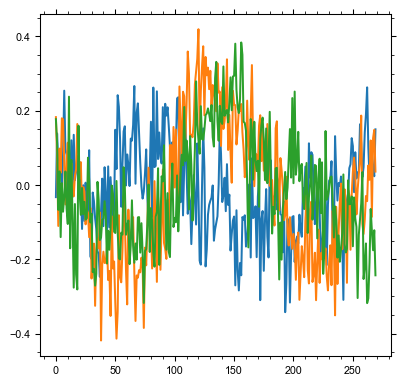

In [12]:
#for model in models:
x = st.multivariate_normal.rvs(cov=acm['CNRM-ESM2-1'], random_state=10)
y = st.multivariate_normal.rvs(cov=acm['CNRM-ESM2-1'], random_state=11)
z = st.multivariate_normal.rvs(cov=acm['CNRM-ESM2-1'], random_state=12)

pl.plot(x[:270])
pl.plot(y[:270])
pl.plot(z[:270])


In [13]:
np.random.seed(seed=360185)
samples = 100000
model_choices = np.random.randint(0, high=len(accepted_models), size=samples)
intvar = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    intvar[:, i] = st.multivariate_normal.rvs(cov=acm[accepted_models[model_choices[i]]], random_state=98426+i*9)[:270]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [14]:
np.savetxt('../data_output/piControl/internal_variability_piControl.txt', intvar)